**You are predicting whether a given tweet is about a real disaster or not.**

In [44]:
import tensorflow
import os

**Using stop words to reduce vocabulary size and preprocess text for better accuracy using nltk**

In [2]:

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_path = '/content/train.csv'
import pandas as pd
df = pd.read_csv(train_path)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**Using Regular Expressions to remove punctuations and any unwanted characters and nltk stop words**

In [7]:
import re
def preprocess(text):
  text = text.lower()
  text = re.sub('[^a-z^\s]',' ',text)
  text = re.sub('\s+',' ',text)
  text = text.split(' ')
  y = []
  for t in text:
    if t in stop_words or len(t)<=2:
      continue
    y.append(t)
  return y

In [8]:
df['text'] = df.text.apply(lambda x: preprocess(x))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgive]",1
1,4,NaN,NaN,"[forest, fire, near, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


**Tokenizer API to convert all the texts to integers**

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [10]:
vocab_size = len(tokenizer.word_index)
vocab_size

21349

In [11]:
word_index = tokenizer.word_index

In [12]:
def convert(text):
  x = []
  for t in text:
    if t in word_index:
      x.append(word_index[t])
  return x

In [13]:
df['text2'] = df.text.apply(lambda x: convert(x))
df.head()

,id,keyword,location,text,target,text2
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgive]",1,"[4145, 689, 143, 54, 1381, 4146]"
1,4,NaN,NaN,"[forest, fire, near, ronge, sask, canada]",1,"[91, 5, 119, 6319, 6320, 1013]"
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1,"[1504, 1382, 1679, 533, 6321, 1505, 144, 1679,..."
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1,"[10, 4147, 1276, 144, 1188, 20]"
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1,"[28, 1014, 206, 6322, 1506, 155, 1276, 6323, 86]"


In [14]:
max_len = 0
for i in df.text2.tolist():
  if len(i)>max_len:
    max_len = len(i)
max_len ## max length of tweet after preprocessing of text

21

In [15]:
text2 = df.text2.tolist()
text2 = tf.keras.utils.pad_sequences(text2,maxlen = max_len,padding = 'post') ## padding input with zeros to get same size

In [16]:
import numpy as np
text2 = np.array(text2)
text2.shape

(7613, 21)

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(text2,df['target'],stratify = df['target'])
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


((5709, 21), (1904, 21), (5709,), (1904,))

In [32]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test,Y_test,stratify =Y_test, train_size = 0.5)
X_val.shape,X_test.shape,Y_val.shape,Y_test.shape


((952, 21), (952, 21), (952,), (952,))

**Use Naive Bayes Classifier to classify the tweet**

In [19]:
from tensorflow.python import train
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
naive_model = MultinomialNB()
naive_model.fit(X_train,Y_train)
y_pred = naive_model.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       543
           1       0.62      0.57      0.60       409

    accuracy                           0.67       952
   macro avg       0.66      0.65      0.66       952
weighted avg       0.66      0.67      0.66       952



**Using Preprocessing of MinMaxScaler to get normalize the data**

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
naive_model = MultinomialNB()
naive_model.fit(X_train,Y_train)
y_pred = naive_model.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.91      0.73       543
           1       0.67      0.26      0.37       409

    accuracy                           0.63       952
   macro avg       0.65      0.58      0.55       952
weighted avg       0.64      0.63      0.58       952



In [21]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(X_train,Y_train)
y_pred = forest_model.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       543
           1       0.69      0.52      0.59       409

    accuracy                           0.69       952
   macro avg       0.69      0.67      0.67       952
weighted avg       0.69      0.69      0.68       952



In [33]:
from sklearn.linear_model import LogisticRegression
regress_model = LogisticRegression()
regress_model.fit(X_train,Y_train)
y_pred = regress_model.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.81      0.72       543
           1       0.63      0.43      0.51       409

    accuracy                           0.65       952
   macro avg       0.64      0.62      0.62       952
weighted avg       0.64      0.65      0.63       952



In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(text2,df['target'],stratify = df['target'])
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((5709, 21), (1904, 21), (5709,), (1904,))

**Using Deep Learning with LSTM for sequential data and Embedding layer to get dense vectors for words**

In [23]:
from tensorflow.keras.layers import Embedding,Dense,Flatten,BatchNormalization,Dropout,LSTM
from tensorflow.keras import Sequential
model = Sequential([
    Embedding(vocab_size+1,100,input_length = max_len,mask_zero = True),
    LSTM(256),
    Dense(1,activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 100)           2135000   
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 2500825 (9.54 MB)
Trainable params: 2500825 (9.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


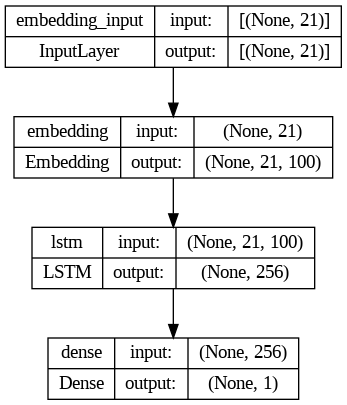

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True)

In [25]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history = model.fit(X_train,Y_train,epochs = 10,batch_size = 32,validation_data = (X_val,Y_val))

Epoch 1/10
179/179 [==============================] - 35s 147ms/step - loss: 0.5301 - accuracy: 0.7359 - val_loss: 0.3208 - val_accuracy: 0.8897
Epoch 2/10
179/179 [==============================] - 23s 128ms/step - loss: 0.2256 - accuracy: 0.9149 - val_loss: 0.1949 - val_accuracy: 0.9265
Epoch 3/10
179/179 [==============================] - 23s 129ms/step - loss: 0.0884 - accuracy: 0.9699 - val_loss: 0.2046 - val_accuracy: 0.9317
Epoch 4/10
179/179 [==============================] - 23s 127ms/step - loss: 0.0448 - accuracy: 0.9870 - val_loss: 0.1932 - val_accuracy: 0.9296
Epoch 5/10
179/179 [==============================] - 22s 125ms/step - loss: 0.0365 - accuracy: 0.9898 - val_loss: 0.2197 - val_accuracy: 0.9349
Epoch 6/10
179/179 [==============================] - 23s 128ms/step - loss: 0.0270 - accuracy: 0.9911 - val_loss: 0.1726 - val_accuracy: 0.9433
Epoch 7/10
179/179 [==============================] - 24s 132ms/step - loss: 0.0175 - accuracy: 0.9928 - val_loss: 0.2254 - val_ac

In [37]:
Accuracy = model.evaluate(X_test,Y_test)[1]

30/30 [==============================] - 1s 17ms/step - loss: 0.2564 - accuracy: 0.9443


In [43]:
print("The accuracy of model on Test data is ",np.float16(Accuracy))

The accuracy of model on Test data is  0.9443
